# Gradient descent - OOP SPT extraction test - attempt 2
Created 17/05/2024

Objectives:
* Implement OOP MPO gradient descent on a small case, calculate fermionic and proj rep cohomologies.
* Similar to [previous attempt](gradient_descent_oop_spt_extraction_test.ipynb), but added a "shape parameter" to unitarity loss.

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../")

In [3]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os
import time

from collections import namedtuple

In [4]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt

In [5]:
from SPTOptimization.utils import (
    to_npc_array
)

from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.Optimizers.MPOGradientDescent import (
    MPOGradientDescent
)

# Load data

In [6]:
DATA_DIR_2 = r"../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [7]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [8]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_2))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_2, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

# Definitons

In [9]:
MAX_VIRTUAL_BOND_DIM = 30
MAX_INTERMEDIATE_VIRTUAL_BOND_DIM = 2*MAX_VIRTUAL_BOND_DIM
# MPO bond dim?
MAX_MPO_BOND_DIM = 50

SVD_CUTOFF = 1e-3

Define bosonic symmetries. Label by the group element added.

In [10]:
np_00 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

np_01 = np.array([
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

np_11 = np.array([
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [1, 0, 0, 0]
])

In [11]:
bosonic_np_symmetries = [
    np_00,
    np_01,
    np_10,
    np_11
]

In [12]:
bosonic_npc_symmetries = [
    to_npc_array(X) for X in bosonic_np_symmetries
]

In [13]:
npc_00 = to_npc_array(np_00)
npc_01 = to_npc_array(np_01)
npc_10 = to_npc_array(np_10)
npc_11 = to_npc_array(np_11)

Define "fermionic symmetries". Just identity and JW string.

In [14]:
np_I = np.array([
    [1, 0],
    [0, 1]
])

np_JW = np.array([
    [1, 0],
    [0, -1]
])

In [15]:
fermionic_np_symmetries = [np_I, np_JW]

In [16]:
fermionic_npc_symmetries = [
    to_npc_array(X) for X in fermionic_np_symmetries
]

In [17]:
npc_JW = fermionic_npc_symmetries[1]

In [18]:
symmetry_actions = [
    [[b, f] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [19]:
shifted_symmetry_actions = [
    [[f, b] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [20]:
cases_non_triv_proj_rep = dict()
psi = loaded_data_non_triv_proj_rep[0]

for i, l in enumerate(symmetry_actions):

    for j, s in enumerate(l):
        case = SymmetryActionWithBoundaryUnitaries(
            psi,
            s*40,
            left_symmetry_index=60,
            left_boundary_unitaries=[np_I, np_00]*1,
            right_boundary_unitaries=[np_00, np_I]*1
        )

        cases_non_triv_proj_rep[(i, j)] = case

In [21]:
for c in cases_non_triv_proj_rep.values():
    c.compute_svd_approximate_expectation()

In [22]:
def get_good_sol_found(unitarity, overlap):
    if (unitarity < 8) and (overlap > 0.9):
        return True
    return False

In [23]:
def get_diverging_sol(unitarity, overlap):
    if unitarity > 1e10:
        return True
    if overlap > 1e10:
        return True
    return False

# Get MPO solutions

## Attempt 1

In [34]:
num_sites = 6

unitarity_learning_rate = 1
overlap_learning_rate = 100

num_iterations = 2000
num_good_sol_followup_iterations = 200
num_potential_sol_followup_iterations = 1000
bond_dimension = 6
num_seeds = 10

In [35]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [36]:
def get_good_sol_found(unitarity, overlap):
    if (unitarity < 10) and (overlap > 0.9):
        return True
    return False

In [37]:
hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(5e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.05, 0.3),
    'beta_2': scipy.stats.uniform(0.05, 0.25),
    'overlap_learning_rate': scipy.stats.randint(80, 180),
    'unitarity_shape_parameter': scipy.stats.uniform(0.01, 0.5),
}

In [38]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [39]:
opt_dict = dict()

for k, case in cases_non_triv_proj_rep.items():
    if (k[1] != 0):
        start = time.time()
        print(k)

        results_dict = dict()
        new_seed_needed = True
        good_sol_found = False

        l=0
        while new_seed_needed:
            start = time.time()
            hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}
            print(hyperparams)


            opt = MPOGradientDescent(
                case,
                num_sites,
                bond_dimension,
                unitarity_learning_rate,
                hyperparams['unitarity_shape_parameter'],
                hyperparams['overlap_learning_rate'],
                (hyperparams['alpha'], hyperparams['beta_1'], hyperparams['beta_2']),
                random_initial_mpo=True
            )

            j = 0
            need_more_iterations = True
            while need_more_iterations:
                opt.grad_desc_one_step()
    
                j += 1

                unitarity = opt.unitarity_scores[-1]
                overlap = opt.mpo_expectations[-1]
    
                good_sol_found = get_good_sol_found(unitarity, overlap)
                diverging_sol = get_diverging_sol(unitarity, overlap)
                need_more_iterations = (
                    (not good_sol_found)
                    and (not diverging_sol)
                    and (j<num_iterations)
                )

            if overlap  > 0.1:
                for _ in range(num_potential_sol_followup_iterations):
                    opt.grad_desc_one_step()

                unitarity = opt.unitarity_scores[-1]
                overlap = opt.mpo_expectations[-1]
    
                good_sol_found = get_good_sol_found(unitarity, overlap)
            
            if good_sol_found:
                for _ in range(num_good_sol_followup_iterations):
                    opt.grad_desc_one_step()

            end = time.time()

            # Saving multiple copies of MPS? This could blow up memory...!
            current_results = {
                'time': (end-start),
                'good_sol': good_sol_found,
                'opt': opt
            }
            
            results_dict[HyperParams(**hyperparams)] = current_results
            print(end - start)
            print(np.real(unitarity))
            print(overlap)
            print()

            l += 1
            new_seed_needed = (
                (not good_sol_found)
                and (l<num_seeds)
            )

        opt_dict[k] = results_dict

(0, 1)
{'alpha': 0.0016629905691140571, 'beta_1': 0.34898965810216404, 'beta_2': 0.148899240049557, 'overlap_learning_rate': 95, 'unitarity_shape_parameter': 0.12115226976679154}
241.6271424293518
4.218713759902585
0.9232060988255215

(0, 2)
{'alpha': 0.0005545360526673085, 'beta_1': 0.28954036731910704, 'beta_2': 0.0824133729768821, 'overlap_learning_rate': 125, 'unitarity_shape_parameter': 0.4887103542331211}
225.14236450195312
0.23495456841021678
7.01907571990742e-07

{'alpha': 0.0014314410898177568, 'beta_1': 0.1988791597095278, 'beta_2': 0.14251813925183598, 'overlap_learning_rate': 101, 'unitarity_shape_parameter': 0.2848452584622533}
227.56932878494263
0.2873563304592608
7.52378391150532e-07

{'alpha': 0.009017840791001621, 'beta_1': 0.0838567472524466, 'beta_2': 0.2126075891584595, 'overlap_learning_rate': 112, 'unitarity_shape_parameter': 0.48684821694908204}
227.1627197265625
15.438254390736233
2.2992491765561343e-05

{'alpha': 0.004291627706226927, 'beta_1': 0.06763263533696

KeyboardInterrupt: 

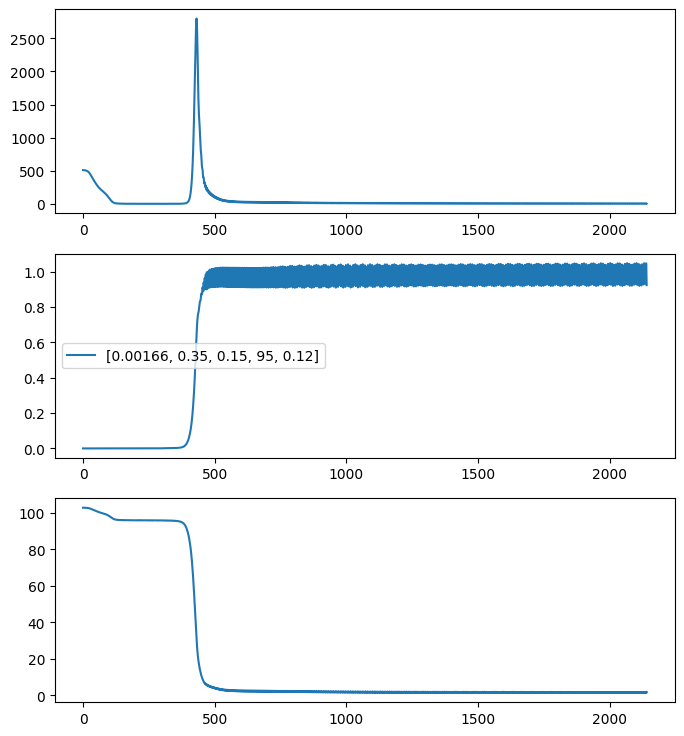

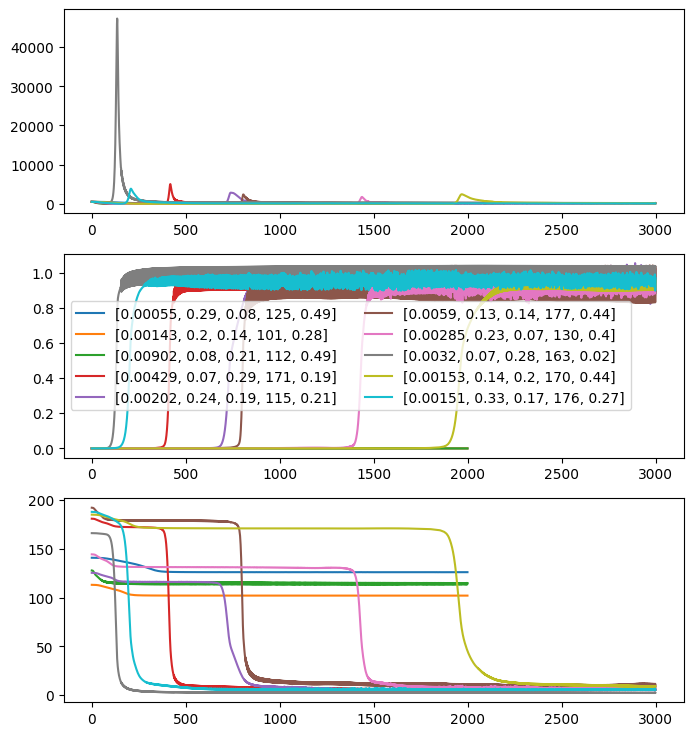

In [40]:
for key, v1 in opt_dict.items(c):
    
    fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))
    
    for k, v in v1.items():
        opt = v['opt']
        label=[np.round(x, 2) for x in k]
        label[0] = np.round(k[0], 5)
        ax1.plot(opt.unitarity_scores)
        ax2.plot(opt.mpo_expectations, label=label)
        opt.compute_training_losses()
        ax3.plot(opt.training_losses)
    
    ax2.legend(loc='center left', ncols=2)

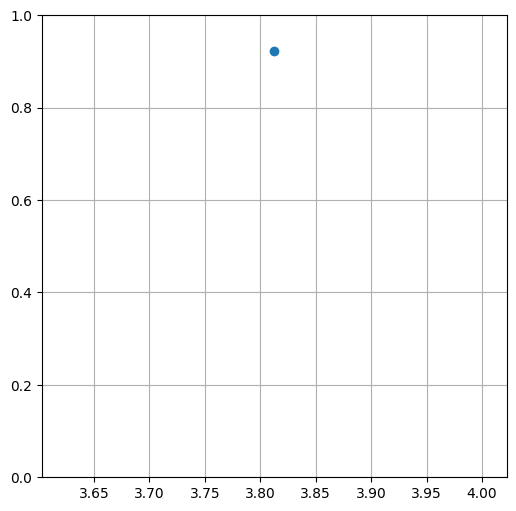

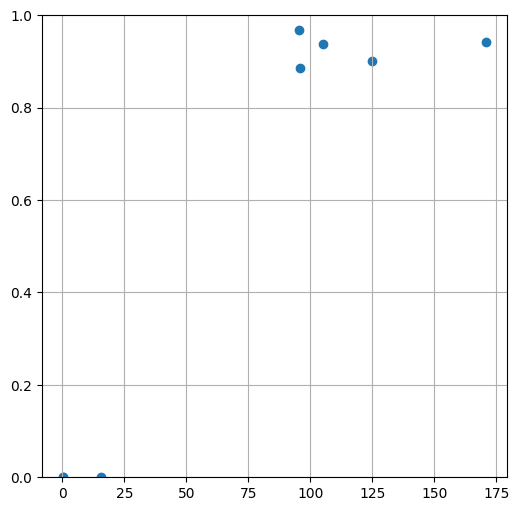

In [41]:
for key, v1 in opt_dict.items():
    
    fig, ax = plt.subplots(figsize=(6, 6))

    final_unitarities = list()
    final_mpo_expectations = list()
    
    for k, v in v1.items():
        opt = v['opt']
        final_unitarities.append(opt.unitarity_scores[-1])
        final_mpo_expectations.append(opt.mpo_expectations[-1])
    
    ax.scatter(final_unitarities, final_mpo_expectations)
    ax.set_ylim(0, 1)
    ax.grid()

## Attempt 2

In [42]:
num_sites = 6

unitarity_learning_rate = 1
overlap_learning_rate = 100

num_iterations = 2000
num_good_sol_followup_iterations = 200
num_potential_sol_followup_iterations = 1000
bond_dimension = 6
num_seeds = 10

In [43]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [44]:
def get_good_sol_found(unitarity, overlap):
    if (unitarity < 10) and (overlap > 0.9):
        return True
    return False

In [45]:
hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 5e-3),
    'beta_1': scipy.stats.uniform(0.05, 0.3),
    'beta_2': scipy.stats.uniform(0.05, 0.25),
    'overlap_learning_rate': scipy.stats.randint(20, 120),
    'unitarity_shape_parameter': scipy.stats.uniform(0.01, 0.5),
}

In [46]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [47]:
opt_dict = dict()

for k, case in cases_non_triv_proj_rep.items():
    if (k[1] != 0):
        start = time.time()
        print(k)

        results_dict = dict()
        new_seed_needed = True
        good_sol_found = False

        l=0
        while new_seed_needed:
            start = time.time()
            hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}
            print(hyperparams)


            opt = MPOGradientDescent(
                case,
                num_sites,
                bond_dimension,
                unitarity_learning_rate,
                hyperparams['unitarity_shape_parameter'],
                hyperparams['overlap_learning_rate'],
                (hyperparams['alpha'], hyperparams['beta_1'], hyperparams['beta_2']),
                random_initial_mpo=True
            )

            j = 0
            need_more_iterations = True
            while need_more_iterations:
                opt.grad_desc_one_step()
    
                j += 1

                unitarity = opt.unitarity_scores[-1]
                overlap = opt.mpo_expectations[-1]
    
                good_sol_found = get_good_sol_found(unitarity, overlap)
                diverging_sol = get_diverging_sol(unitarity, overlap)
                need_more_iterations = (
                    (not good_sol_found)
                    and (not diverging_sol)
                    and (j<num_iterations)
                )

            if overlap  > 0.1:
                for _ in range(num_potential_sol_followup_iterations):
                    opt.grad_desc_one_step()

                unitarity = opt.unitarity_scores[-1]
                overlap = opt.mpo_expectations[-1]
    
                good_sol_found = get_good_sol_found(unitarity, overlap)
            
            if good_sol_found:
                for _ in range(num_good_sol_followup_iterations):
                    opt.grad_desc_one_step()

            end = time.time()

            # Saving multiple copies of MPS? This could blow up memory...!
            current_results = {
                'time': (end-start),
                'good_sol': good_sol_found,
                'opt': opt
            }
            
            results_dict[HyperParams(**hyperparams)] = current_results
            print(end - start)
            print(np.real(unitarity))
            print(overlap)
            print()

            l += 1
            new_seed_needed = (
                (not good_sol_found)
                and (l<num_seeds)
            )

        opt_dict[k] = results_dict

(0, 1)
{'alpha': 0.0001461645915684856, 'beta_1': 0.13634797896406878, 'beta_2': 0.07066186345739266, 'overlap_learning_rate': 31, 'unitarity_shape_parameter': 0.04737038786774527}
212.92875695228577
39.34475220171976
0.0001647490072127074

{'alpha': 0.001894183686798866, 'beta_1': 0.10238607094900867, 'beta_2': 0.12836173431013098, 'overlap_learning_rate': 102, 'unitarity_shape_parameter': 0.24698919743369002}
231.20628571510315
5.198622634546268
0.9450729390061343

(0, 2)
{'alpha': 0.0009484429053530468, 'beta_1': 0.18750512640329775, 'beta_2': 0.1321980335827766, 'overlap_learning_rate': 70, 'unitarity_shape_parameter': 0.07640578058948781}
322.13415026664734
130.50044249293705
0.9989912808943997

{'alpha': 0.00034726416404296385, 'beta_1': 0.21166060118123237, 'beta_2': 0.28523138380818214, 'overlap_learning_rate': 99, 'unitarity_shape_parameter': 0.15666149819628622}
314.52626276016235
136.85860994546658
0.9326456894176197

{'alpha': 0.003539992124269379, 'beta_1': 0.3048592296501

KeyboardInterrupt: 

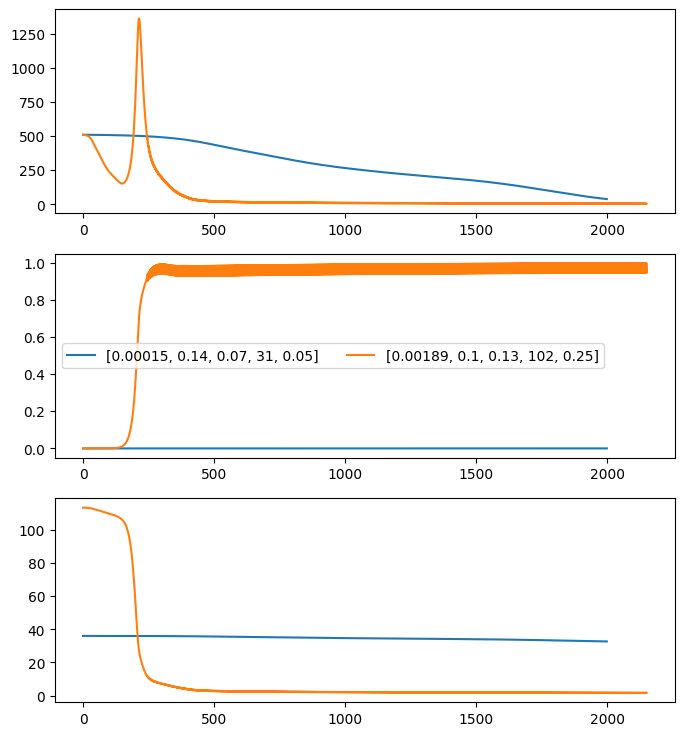

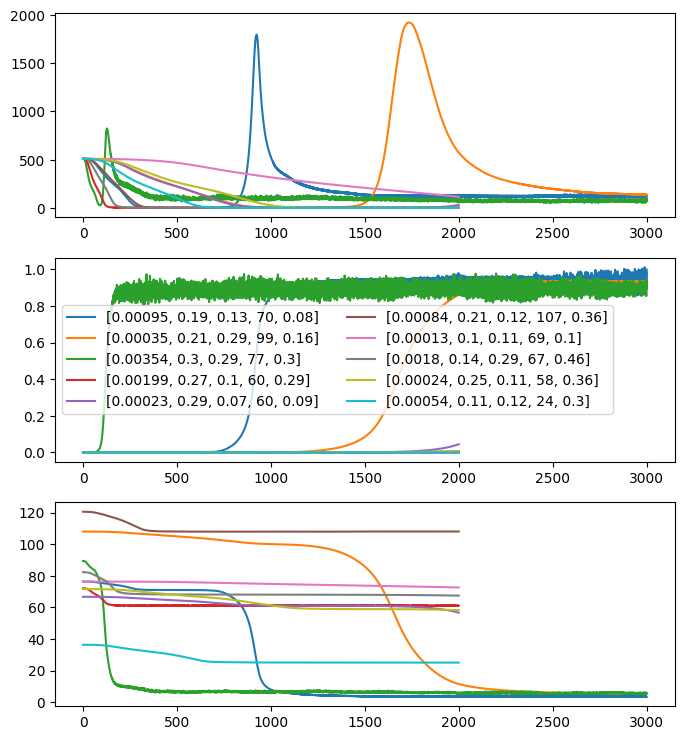

In [48]:
for key, v1 in opt_dict.items():
    
    fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))
    
    for k, v in v1.items():
        opt = v['opt']
        label=[np.round(x, 2) for x in k]
        label[0] = np.round(k[0], 5)
        ax1.plot(opt.unitarity_scores)
        ax2.plot(opt.mpo_expectations, label=label)
        opt.compute_training_losses()
        ax3.plot(opt.training_losses)
    
    ax2.legend(loc='center left', ncols=2)

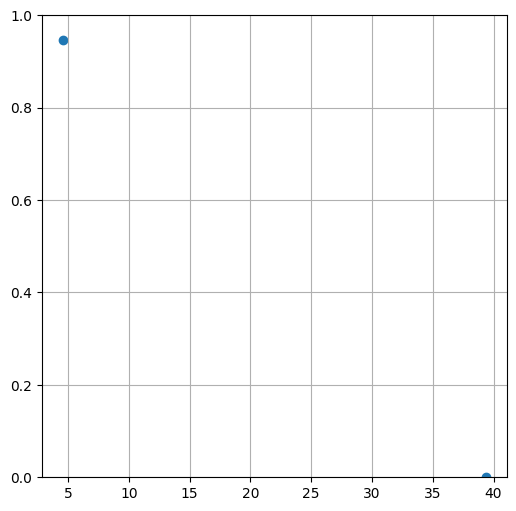

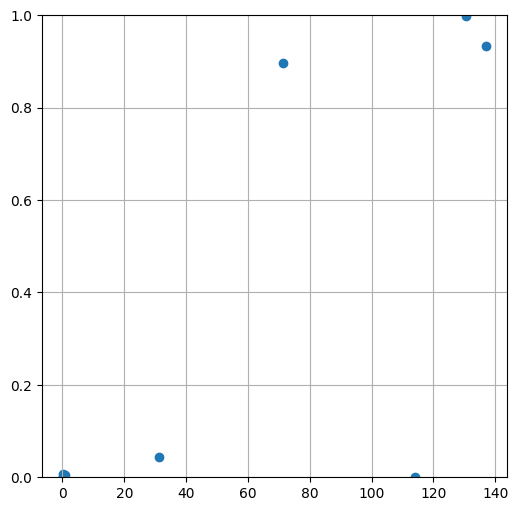

In [49]:
for key, v1 in opt_dict.items():
    
    fig, ax = plt.subplots(figsize=(6, 6))

    final_unitarities = list()
    final_mpo_expectations = list()
    
    for k, v in v1.items():
        opt = v['opt']
        final_unitarities.append(opt.unitarity_scores[-1])
        final_mpo_expectations.append(opt.mpo_expectations[-1])
    
    ax.scatter(final_unitarities, final_mpo_expectations)
    ax.set_ylim(0, 1)
    ax.grid()

## Attempt 3

In [24]:
num_sites = 5

unitarity_learning_rate = 1
overlap_learning_rate = 100

num_iterations = 2000
num_good_sol_followup_iterations = 200
num_potential_sol_followup_iterations = 1000
bond_dimension = 6
num_seeds = 10

In [25]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [26]:
def get_good_sol_found(unitarity, overlap):
    if (unitarity < 10) and (overlap > 0.9):
        return True
    return False

In [27]:
hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 5e-3),
    'beta_1': scipy.stats.uniform(0.05, 0.3),
    'beta_2': scipy.stats.uniform(0.05, 0.25),
    'overlap_learning_rate': scipy.stats.randint(20, 120),
    'unitarity_shape_parameter': scipy.stats.uniform(0.01, 0.5),
}

In [28]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [29]:
opt_dict = dict()

for k, case in cases_non_triv_proj_rep.items():
    if (k[1] != 0):
        start = time.time()
        print(k)

        results_dict = dict()
        new_seed_needed = True
        good_sol_found = False

        l=0
        while new_seed_needed:
            start = time.time()
            hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}
            print(hyperparams)


            opt = MPOGradientDescent(
                case,
                num_sites,
                bond_dimension,
                unitarity_learning_rate,
                hyperparams['unitarity_shape_parameter'],
                hyperparams['overlap_learning_rate'],
                (hyperparams['alpha'], hyperparams['beta_1'], hyperparams['beta_2']),
                random_initial_mpo=True
            )

            j = 0
            need_more_iterations = True
            while need_more_iterations:
                opt.grad_desc_one_step()
    
                j += 1

                unitarity = opt.unitarity_scores[-1]
                overlap = opt.mpo_expectations[-1]
    
                good_sol_found = get_good_sol_found(unitarity, overlap)
                diverging_sol = get_diverging_sol(unitarity, overlap)
                need_more_iterations = (
                    (not good_sol_found)
                    and (not diverging_sol)
                    and (j<num_iterations)
                )

            if overlap  > 0.1:
                for _ in range(num_potential_sol_followup_iterations):
                    opt.grad_desc_one_step()

                unitarity = opt.unitarity_scores[-1]
                overlap = opt.mpo_expectations[-1]
    
                good_sol_found = get_good_sol_found(unitarity, overlap)
            
            if good_sol_found:
                for _ in range(num_good_sol_followup_iterations):
                    opt.grad_desc_one_step()

            end = time.time()

            # Saving multiple copies of MPS? This could blow up memory...!
            current_results = {
                'time': (end-start),
                'good_sol': good_sol_found,
                'opt': opt
            }
            
            results_dict[HyperParams(**hyperparams)] = current_results
            print(end - start)
            print(np.real(unitarity))
            print(overlap)
            print()

            l += 1
            new_seed_needed = (
                (not good_sol_found)
                and (l<num_seeds)
            )

        opt_dict[k] = results_dict

(0, 1)
{'alpha': 0.00011166837024139972, 'beta_1': 0.054461650796916374, 'beta_2': 0.2871211263480554, 'overlap_learning_rate': 108, 'unitarity_shape_parameter': 0.4801083267302598}
184.67177438735962
136.4976458171594
0.003056039972549984

{'alpha': 0.0004545669263335971, 'beta_1': 0.09526862995325333, 'beta_2': 0.15598857830568258, 'overlap_learning_rate': 31, 'unitarity_shape_parameter': 0.3850401281423673}
304.80515718460083
0.8111067115532364
0.93588339928848

(0, 2)
{'alpha': 0.0042145133325325644, 'beta_1': 0.13349808668809196, 'beta_2': 0.25598817380574795, 'overlap_learning_rate': 110, 'unitarity_shape_parameter': 0.44664499003257147}
258.68402647972107
47.779538675289416
1.0144150737537174

{'alpha': 0.0002138286101761554, 'beta_1': 0.1504706021331203, 'beta_2': 0.06572130537671385, 'overlap_learning_rate': 47, 'unitarity_shape_parameter': 0.37134482616909176}
171.9427354335785
0.27135109036188965
0.004593283479148042

{'alpha': 0.000630423918084662, 'beta_1': 0.2109026029686

KeyboardInterrupt: 

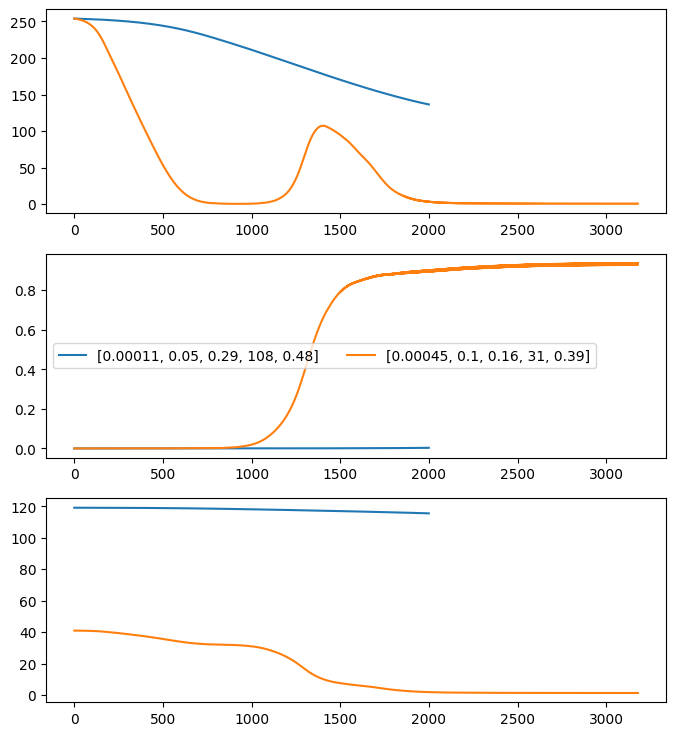

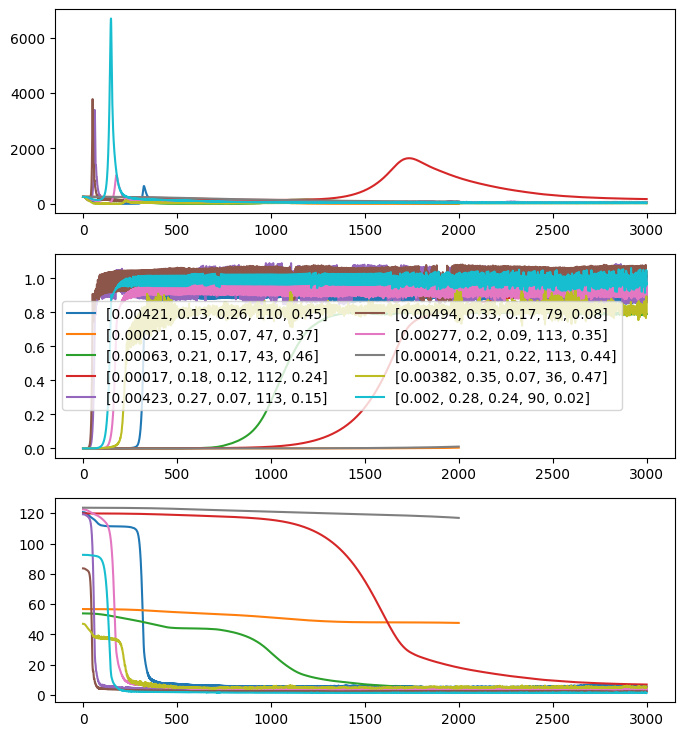

In [30]:
for key, v1 in opt_dict.items():
    
    fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))
    
    for k, v in v1.items():
        opt = v['opt']
        label=[np.round(x, 2) for x in k]
        label[0] = np.round(k[0], 5)
        ax1.plot(opt.unitarity_scores)
        ax2.plot(opt.mpo_expectations, label=label)
        opt.compute_training_losses()
        ax3.plot(opt.training_losses)
    
    ax2.legend(loc='center left', ncols=2)

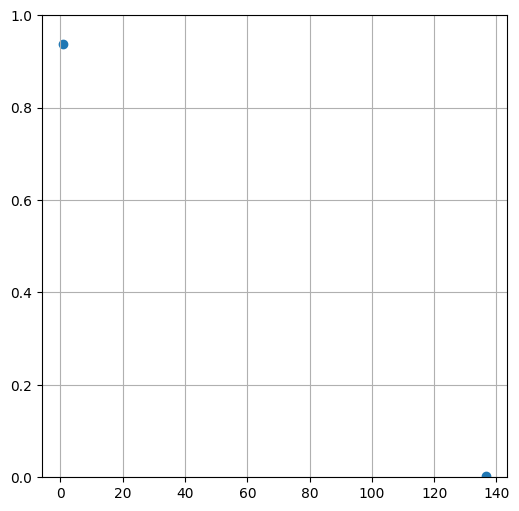

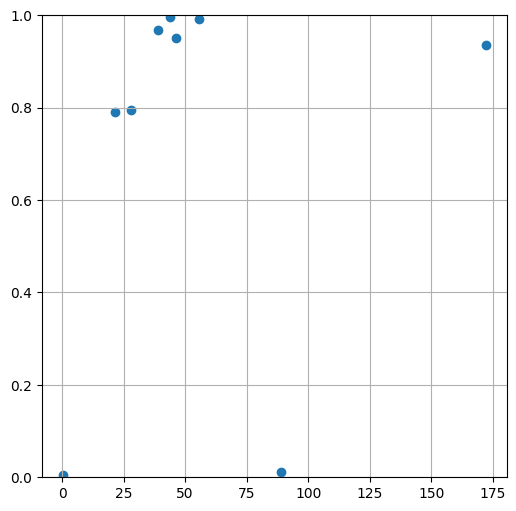

In [31]:
for key, v1 in opt_dict.items():
    
    fig, ax = plt.subplots(figsize=(6, 6))

    final_unitarities = list()
    final_mpo_expectations = list()
    
    for k, v in v1.items():
        opt = v['opt']
        final_unitarities.append(opt.unitarity_scores[-1])
        final_mpo_expectations.append(opt.mpo_expectations[-1])
    
    ax.scatter(final_unitarities, final_mpo_expectations)
    ax.set_ylim(0, 1)
    ax.grid()

## Attempt 4

In [32]:
num_sites = 4

unitarity_learning_rate = 1
overlap_learning_rate = 100

num_iterations = 2000
num_good_sol_followup_iterations = 200
num_potential_sol_followup_iterations = 1000
bond_dimension = 6
num_seeds = 10

In [33]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [34]:
def get_good_sol_found(unitarity, overlap):
    if (unitarity < 10) and (overlap > 0.9):
        return True
    return False

In [35]:
hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 5e-3),
    'beta_1': scipy.stats.uniform(0.05, 0.3),
    'beta_2': scipy.stats.uniform(0.05, 0.25),
    'overlap_learning_rate': scipy.stats.randint(20, 120),
    'unitarity_shape_parameter': scipy.stats.uniform(0.01, 0.5),
}

In [36]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [37]:
opt_dict = dict()

for k, case in cases_non_triv_proj_rep.items():
    if (k[1] != 0):
        start = time.time()
        print(k)

        results_dict = dict()
        new_seed_needed = True
        good_sol_found = False

        l=0
        while new_seed_needed:
            start = time.time()
            hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}
            print(hyperparams)


            opt = MPOGradientDescent(
                case,
                num_sites,
                bond_dimension,
                unitarity_learning_rate,
                hyperparams['unitarity_shape_parameter'],
                hyperparams['overlap_learning_rate'],
                (hyperparams['alpha'], hyperparams['beta_1'], hyperparams['beta_2']),
                random_initial_mpo=True
            )

            j = 0
            need_more_iterations = True
            while need_more_iterations:
                opt.grad_desc_one_step()
    
                j += 1

                unitarity = opt.unitarity_scores[-1]
                overlap = opt.mpo_expectations[-1]
    
                good_sol_found = get_good_sol_found(unitarity, overlap)
                diverging_sol = get_diverging_sol(unitarity, overlap)
                need_more_iterations = (
                    (not good_sol_found)
                    and (not diverging_sol)
                    and (j<num_iterations)
                )

            if overlap  > 0.1:
                for _ in range(num_potential_sol_followup_iterations):
                    opt.grad_desc_one_step()

                unitarity = opt.unitarity_scores[-1]
                overlap = opt.mpo_expectations[-1]
    
                good_sol_found = get_good_sol_found(unitarity, overlap)
            
            if good_sol_found:
                for _ in range(num_good_sol_followup_iterations):
                    opt.grad_desc_one_step()

            end = time.time()

            # Saving multiple copies of MPS? This could blow up memory...!
            current_results = {
                'time': (end-start),
                'good_sol': good_sol_found,
                'opt': opt
            }
            
            results_dict[HyperParams(**hyperparams)] = current_results
            print(end - start)
            print(np.real(unitarity))
            print(overlap)
            print()

            l += 1
            new_seed_needed = (
                (not good_sol_found)
                and (l<num_seeds)
            )

        opt_dict[k] = results_dict

(0, 1)
{'alpha': 0.00059682932656741, 'beta_1': 0.16382698306408694, 'beta_2': 0.09320153053072823, 'overlap_learning_rate': 77, 'unitarity_shape_parameter': 0.04509731604086142}
140.3041536808014
4.5481830165570045
0.9885787581083303

(0, 2)
{'alpha': 0.003327767611632679, 'beta_1': 0.17122776096261205, 'beta_2': 0.13306132839442936, 'overlap_learning_rate': 84, 'unitarity_shape_parameter': 0.12271960685458543}
196.84883761405945
35.06922275038417
0.9164786423625243

{'alpha': 0.0003632353439588314, 'beta_1': 0.22914940038425796, 'beta_2': 0.1792331329196194, 'overlap_learning_rate': 53, 'unitarity_shape_parameter': 0.4307375477194549}
183.54553651809692
18.700136898383136
0.8768053601667513

{'alpha': 0.00033757912153734677, 'beta_1': 0.33500627721445597, 'beta_2': 0.22680978099702043, 'overlap_learning_rate': 79, 'unitarity_shape_parameter': 0.42139881057084394}
182.2797429561615
23.695559532822628
0.9215102012248406

{'alpha': 0.0004165351117466156, 'beta_1': 0.06570244900516273, '

KeyboardInterrupt: 

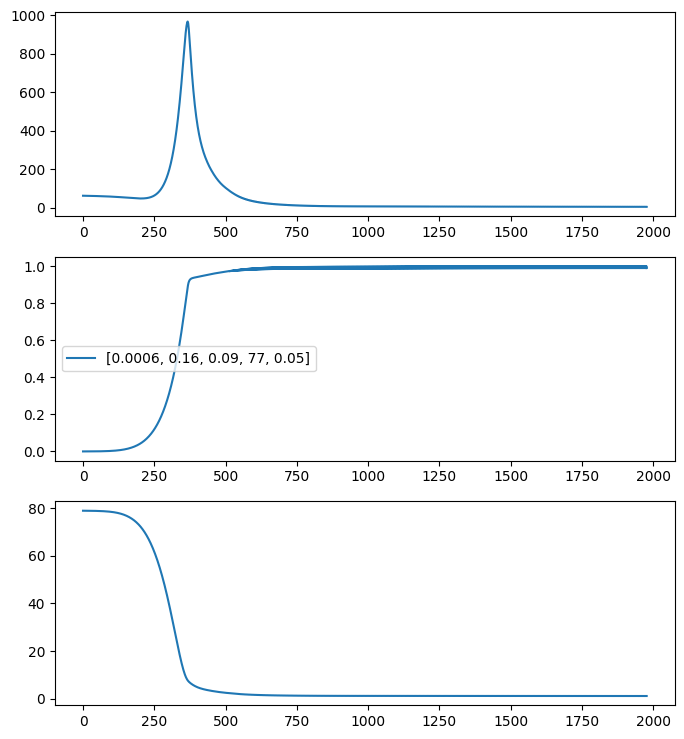

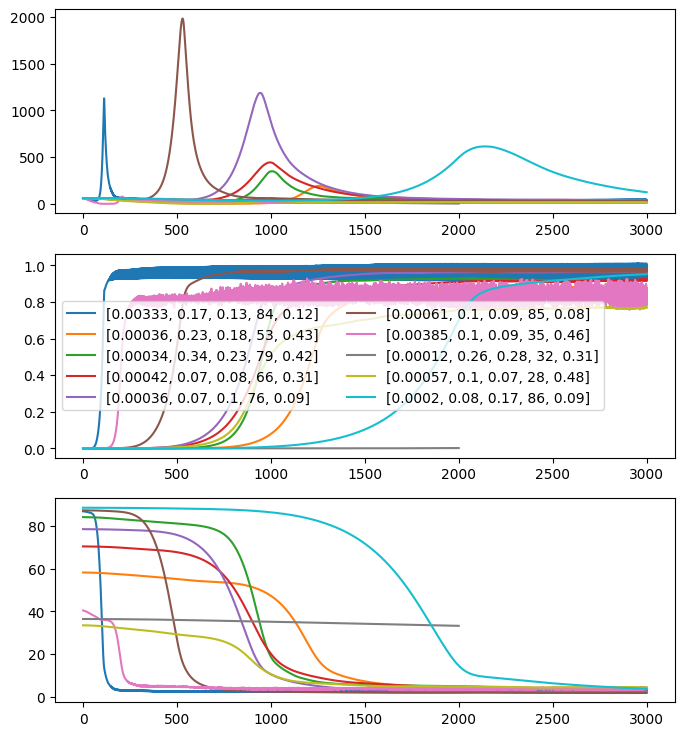

In [38]:
for key, v1 in opt_dict.items():
    
    fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))
    
    for k, v in v1.items():
        opt = v['opt']
        label=[np.round(x, 2) for x in k]
        label[0] = np.round(k[0], 5)
        ax1.plot(opt.unitarity_scores)
        ax2.plot(opt.mpo_expectations, label=label)
        opt.compute_training_losses()
        ax3.plot(opt.training_losses)
    
    ax2.legend(loc='center left', ncols=2)

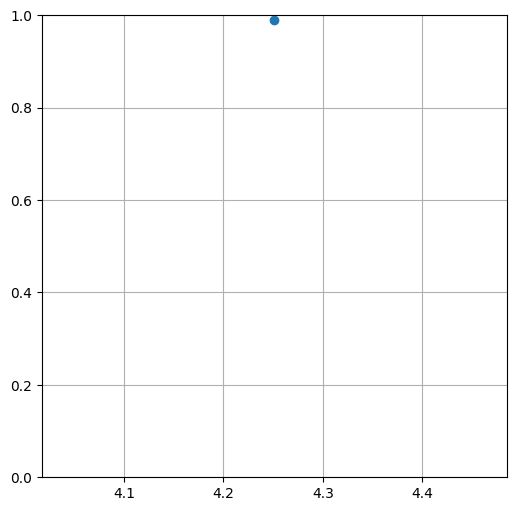

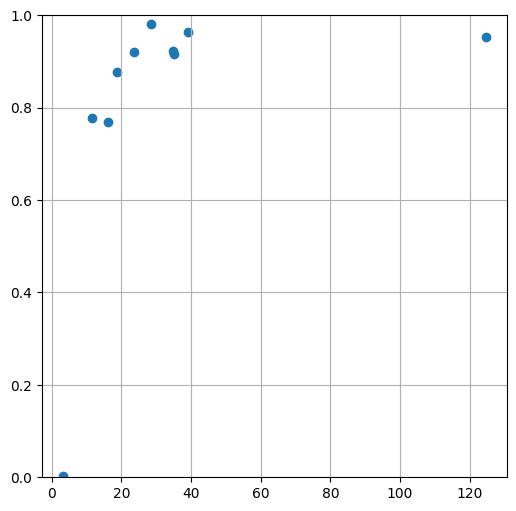

In [39]:
for key, v1 in opt_dict.items():
    
    fig, ax = plt.subplots(figsize=(6, 6))

    final_unitarities = list()
    final_mpo_expectations = list()
    
    for k, v in v1.items():
        opt = v['opt']
        final_unitarities.append(opt.unitarity_scores[-1])
        final_mpo_expectations.append(opt.mpo_expectations[-1])
    
    ax.scatter(final_unitarities, final_mpo_expectations)
    ax.set_ylim(0, 1)
    ax.grid()

## Attempt 5

In [40]:
num_sites = 3

unitarity_learning_rate = 1
overlap_learning_rate = 100

num_iterations = 2000
num_good_sol_followup_iterations = 200
num_potential_sol_followup_iterations = 1000
bond_dimension = 6
num_seeds = 10

In [41]:
physical_dims = [2,]*num_sites
virtual_dims = (
    [(None, bond_dimension),] +
    [(bond_dimension, bond_dimension)]*(num_sites - 2) +
    [(bond_dimension, None),]
)

In [42]:
def get_good_sol_found(unitarity, overlap):
    if (unitarity < 10) and (overlap > 0.9):
        return True
    return False

In [43]:
hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 5e-3),
    'beta_1': scipy.stats.uniform(0.05, 0.3),
    'beta_2': scipy.stats.uniform(0.05, 0.25),
    'overlap_learning_rate': scipy.stats.randint(20, 120),
    'unitarity_shape_parameter': scipy.stats.uniform(0.01, 0.5),
}

In [44]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [45]:
opt_dict = dict()

for k, case in cases_non_triv_proj_rep.items():
    if (k[1] != 0):
        start = time.time()
        print(k)

        results_dict = dict()
        new_seed_needed = True
        good_sol_found = False

        l=0
        while new_seed_needed:
            start = time.time()
            hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}
            print(hyperparams)


            opt = MPOGradientDescent(
                case,
                num_sites,
                bond_dimension,
                unitarity_learning_rate,
                hyperparams['unitarity_shape_parameter'],
                hyperparams['overlap_learning_rate'],
                (hyperparams['alpha'], hyperparams['beta_1'], hyperparams['beta_2']),
                random_initial_mpo=True
            )

            j = 0
            need_more_iterations = True
            while need_more_iterations:
                opt.grad_desc_one_step()
    
                j += 1

                unitarity = opt.unitarity_scores[-1]
                overlap = opt.mpo_expectations[-1]
    
                good_sol_found = get_good_sol_found(unitarity, overlap)
                diverging_sol = get_diverging_sol(unitarity, overlap)
                need_more_iterations = (
                    (not good_sol_found)
                    and (not diverging_sol)
                    and (j<num_iterations)
                )

            if overlap  > 0.1:
                for _ in range(num_potential_sol_followup_iterations):
                    opt.grad_desc_one_step()

                unitarity = opt.unitarity_scores[-1]
                overlap = opt.mpo_expectations[-1]
    
                good_sol_found = get_good_sol_found(unitarity, overlap)
            
            if good_sol_found:
                for _ in range(num_good_sol_followup_iterations):
                    opt.grad_desc_one_step()

            end = time.time()

            # Saving multiple copies of MPS? This could blow up memory...!
            current_results = {
                'time': (end-start),
                'good_sol': good_sol_found,
                'opt': opt
            }
            
            results_dict[HyperParams(**hyperparams)] = current_results
            print(end - start)
            print(np.real(unitarity))
            print(overlap)
            print()

            l += 1
            new_seed_needed = (
                (not good_sol_found)
                and (l<num_seeds)
            )

        opt_dict[k] = results_dict

(0, 1)
{'alpha': 0.0007184838555202212, 'beta_1': 0.31005220339480727, 'beta_2': 0.13971657136971694, 'overlap_learning_rate': 92, 'unitarity_shape_parameter': 0.36404013164239385}
75.01942610740662
4.9283646509954195
0.9736702662072249

(0, 2)
{'alpha': 0.00014180494353407922, 'beta_1': 0.19658392580357076, 'beta_2': 0.07447934435769883, 'overlap_learning_rate': 34, 'unitarity_shape_parameter': 0.27615623048866617}
123.53647351264954
58.24560777290388
0.7895288860287903

{'alpha': 0.0005234502299974365, 'beta_1': 0.2880574827048915, 'beta_2': 0.1729538164020049, 'overlap_learning_rate': 69, 'unitarity_shape_parameter': 0.0383811731653893}
123.80125951766968
27.448510329047977
0.9798916454694556

{'alpha': 0.002752314311378607, 'beta_1': 0.3005737836300259, 'beta_2': 0.07460382144516552, 'overlap_learning_rate': 50, 'unitarity_shape_parameter': 0.4371807779486533}
122.33465766906738
27.709496304206567
0.9720411517583794

{'alpha': 0.00040303809008492106, 'beta_1': 0.17941626273646316, 

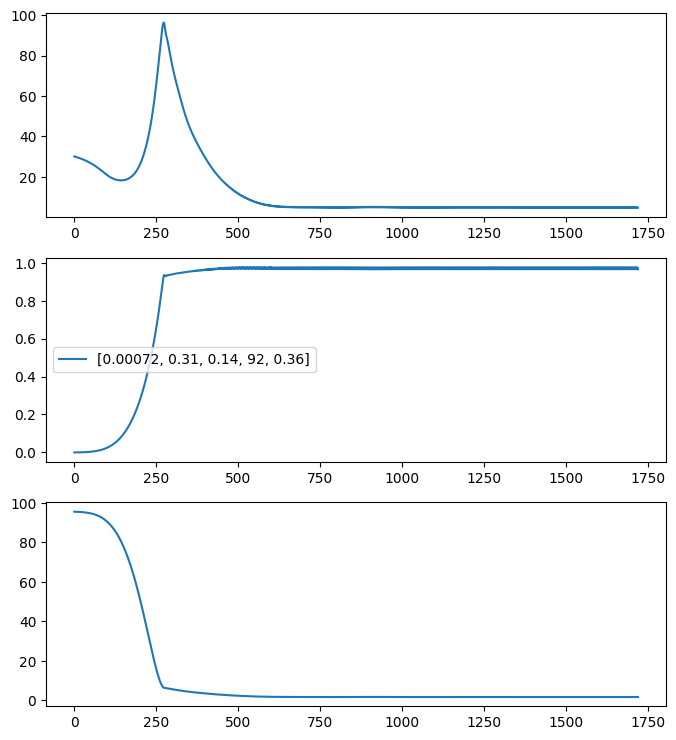

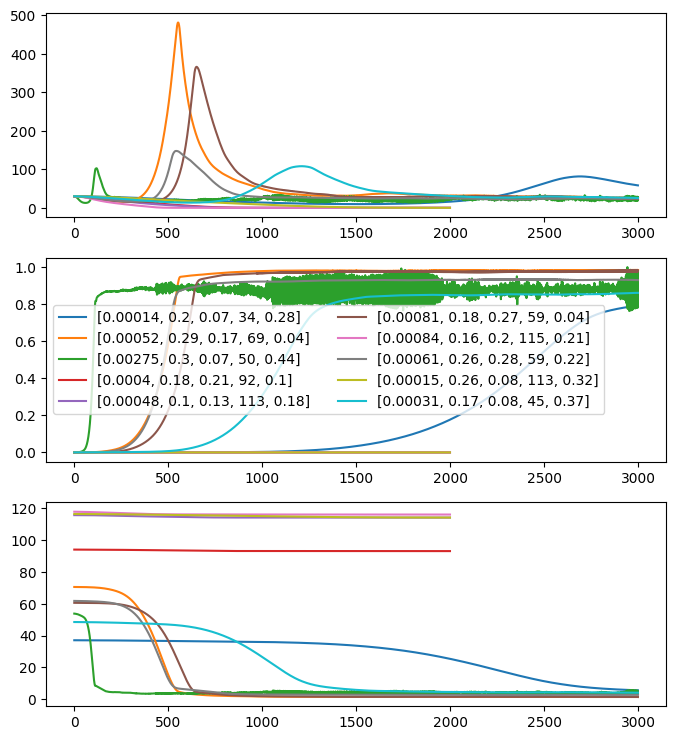

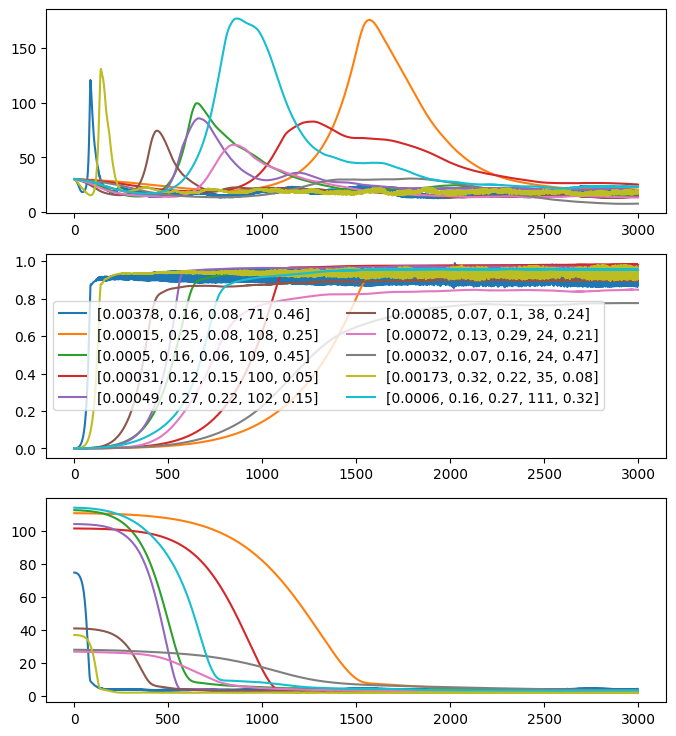

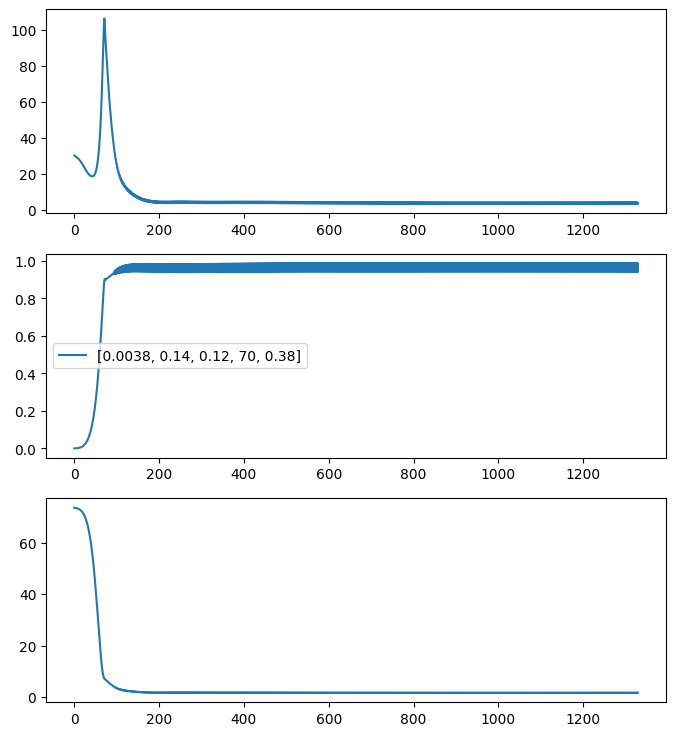

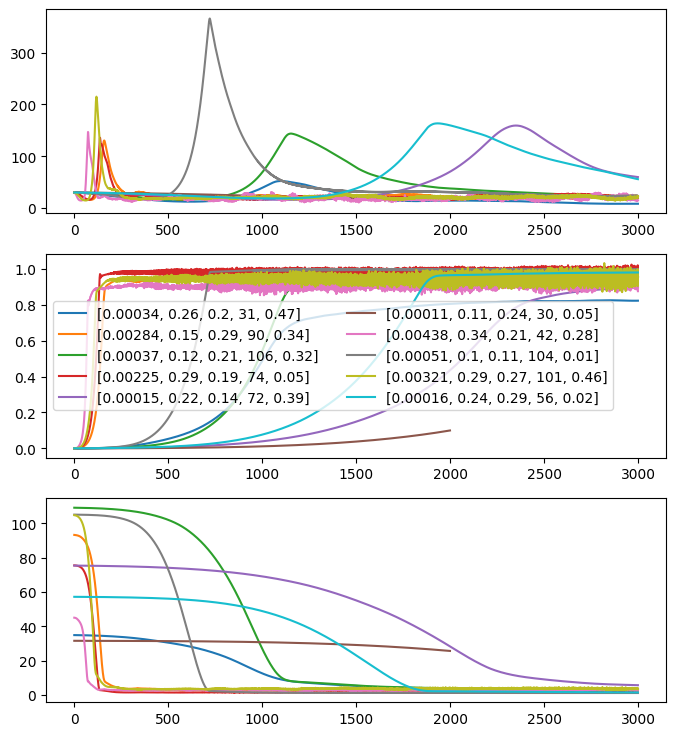

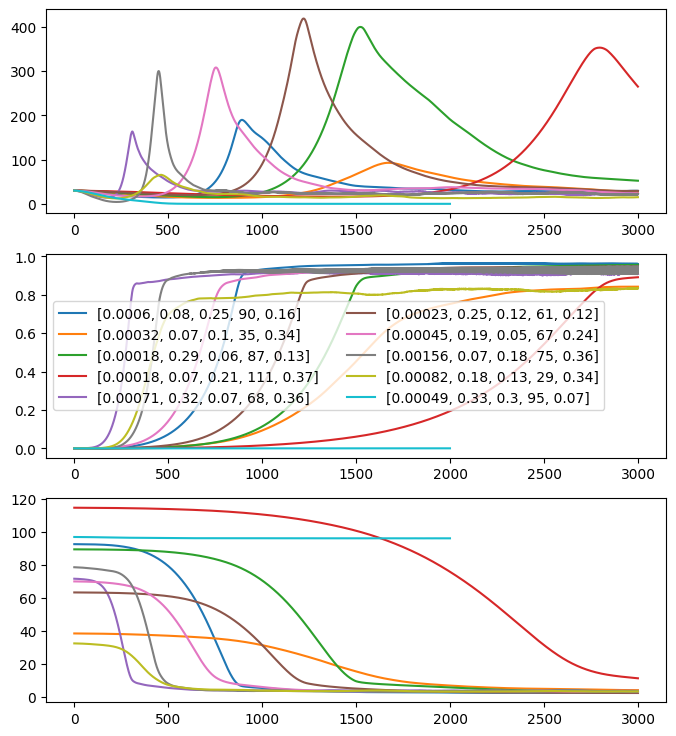

In [46]:
for key, v1 in opt_dict.items():
    
    fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(8, 9))
    
    for k, v in v1.items():
        opt = v['opt']
        label=[np.round(x, 2) for x in k]
        label[0] = np.round(k[0], 5)
        ax1.plot(opt.unitarity_scores)
        ax2.plot(opt.mpo_expectations, label=label)
        opt.compute_training_losses()
        ax3.plot(opt.training_losses)
    
    ax2.legend(loc='center left', ncols=2)

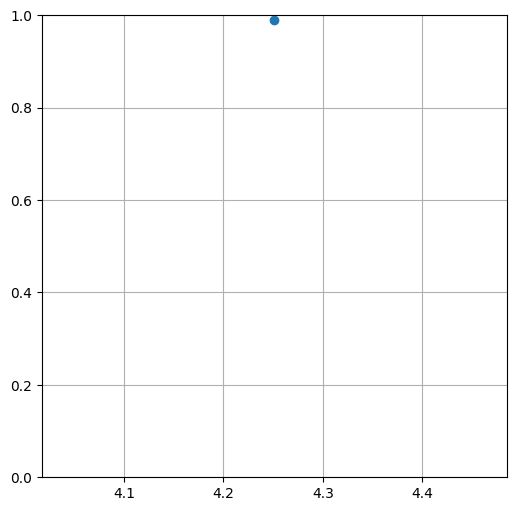

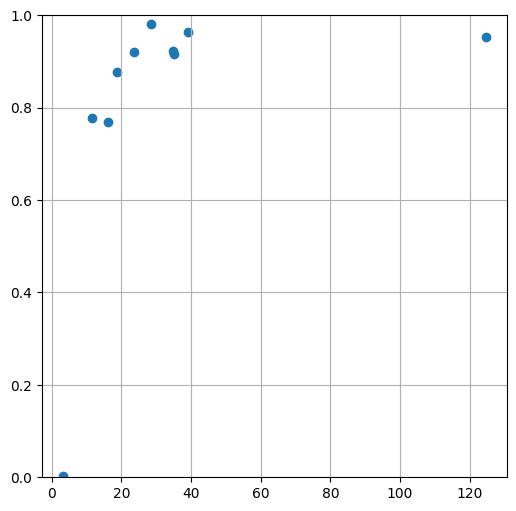

In [39]:
for key, v1 in opt_dict.items():
    
    fig, ax = plt.subplots(figsize=(6, 6))

    final_unitarities = list()
    final_mpo_expectations = list()
    
    for k, v in v1.items():
        opt = v['opt']
        final_unitarities.append(opt.unitarity_scores[-1])
        final_mpo_expectations.append(opt.mpo_expectations[-1])
    
    ax.scatter(final_unitarities, final_mpo_expectations)
    ax.set_ylim(0, 1)
    ax.grid()

# Conclusion
Still have trouble converging...